<a href="https://colab.research.google.com/github/pabloswfly/CNN-vis/blob/master/genomcmcgan_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that we have learn to do demographic simulations with msprime, we can start building our discriminator with the permutation invariance property. The discriminator in the beginning will tell apart simulations with a difference in a single parameter, such as mutation rate, recombination rate, effective size, etc.

In [ ]:
%%capture
# Installing required libraries
!apt-get install python-dev libgsl0-dev

# The latest version of tskit 0.3 gives problem with msprime
!pip install tskit==0.2.3 zarr msprime stdpopsim tensorflow

In [ ]:
# Importing libraries and modules
import msprime
import stdpopsim
import zarr
import random
import pickle
import imageio
import bisect
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import tensorflow_probability as tfp
print(tfp.__version__)
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split


# Mount my Gdrive disk
from google.colab import drive, files
drive.mount('/content/gdrive')
!mkdir /content/results

print(tf.config.list_physical_devices())
# A hopeless try to avoid the GPU going OOM
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
 class Genobuilder():
    """Class for building genotype matrices from msprime, stdpopsim
      or empirical data read from Zarr directories, and other utilities
      relates to these"""

    def __init__(self, source, num_samples, seq_len, maf_thresh,
                 fixed_dim = 128, scale=True, **kwargs):
      self._num_samples = num_samples
      self._seq_len = seq_len
      self._maf_thresh = maf_thresh
      self._source = source
      self._fixed_dim = fixed_dim
      self._scale = scale
      self._param_bounds = None
      self._num_reps = None
      super(Genobuilder, self).__init__(**kwargs)

    
    def set_parameters(self, sim_source, param_name, fixed_val, 
                       param_bounds, log_scale):
      
      self._sim_source = sim_source
      self._param_name = param_name
      self._param_bounds = param_bounds
      self._log_scale = log_scale
      if log_scale:
        # float_power allows to use negative numbers as exponent
        self._fixed_val = np.float_power(10, fixed_val)
      else:
        self._fixed_val = fixed_val


    @property
    def num_samples(self):
      return self._num_samples

    @property
    def seq_len(self):
      return self._seq_len

    @property
    def maf_thresh(self):
      return self._maf_thresh

    @property
    def source(self):
      return self._source

    @property
    def fixed_dim(self):
      return self._fixed_dim

    @property
    def num_reps(self):
      return self._num_reps

    @property
    def fixed_val(self):
      return self._fixed_val

    @property
    def param_bounds(self):
      return self._param_bounds

    @property
    def sim_source(self):
      return self._sim_source

    @property
    def param_name(self):
      return self._param_name

    @property
    def log_scale(self):
      return self._log_scale

    @property
    def scale(self):
      return self._scale


    @num_samples.setter
    def num_samples(self, n):
      if type(n) != int or n < 0:
        raise ValueError('Genobuilder num_samples must be a positive integer')
      self._num_samples = n

    @maf_thresh.setter
    def maf_thresh(self, maf):
      if maf < 0 or maf > 1:
        raise ValueError('The Minor Allele Frequency must be between 0 and 1')
      self._maf_thresh = maf

    @seq_len.setter
    def seq_len(self, l):
      self._seq_len = int(l)  

    @source.setter
    def source(self, s):
      if s not in ['msprime', 'stdpopsim', 'empirical']:
        raise ValueError('Genobuilder source must be either msprime, '
                         'stdpopsim or empirical')
      self._source = s

    @fixed_dim.setter
    def fixed_dim(self, f):
      if f % 2 != 0:
        raise ValueError('We recommend the fixed dimension to be multiple of 2')
      self._fixed_dim = f

    @num_reps.setter
    def num_reps(self, n):
      self._num_reps = n

    @fixed_val.setter
    def fixed_val(self, v):
      if self._log_scale:
        self._fixed_val = np.float_power(10, v)
      else:
        self._fixed_val = v 

    @param_bounds.setter
    def param_bounds(self, b):
      if type(b) is not tuple:
        raise ValueError('We recommend the fixed dimension to be multiple of 2')
      self._param_bounds = b

    @sim_source.setter
    def sim_source(self, s):
      if s not in ['msprime', 'stdpopsim']:
        raise ValueError('Genobuilder sim_source must be either', 
                         'msprime or stdpopsim')
      self._sim_source = s 

    @param_name.setter
    def param_name(self, n):
      if n not in ['recomb', 'mutation', 'effective', 'growth']:
        raise ValueError('Genobuilder param_name must be either', 
                         'recomb, mutation, effective or growth')
      self._param_name = n 

    @log_scale.setter
    def log_scale(self, l):
      if type(l) is not bool:
        raise ValueError('log_scale must be either True or False')
      self._log_scale = l 



    def _simulate_msprime(self, seed=None):
      """Simulate demographic data, returning a tensor with n_reps number 
      of genotype matrices"""

      if self.param_name=='recomb':
        sims = msprime.simulate(
            sample_size=self.num_samples, Ne=10000, length=self.seq_len, 
            mutation_rate=1e-8, recombination_rate=self.fixed_val, 
            num_replicates=self.num_reps, random_seed=seed)
        
      elif self.param_name=='mutation':
        sims = msprime.simulate(
            sample_size=self.num_samples, Ne=10000, length=self.seq_len, 
            mutation_rate=self.fixed_val, recombination_rate=1e-8, 
            num_replicates=self.num_reps, random_seed=seed)
        
      elif self.param_name=='effective':
        sims = msprime.simulate(
            sample_size=self.num_samples, Ne=self.fixed_val, 
            length=self.seq_len, mutation_rate=1e-8, recombination_rate=1e-8, 
            num_replicates=self.num_reps, random_seed=seed)
        
      elif self.param_name=='growth':
        popconfig = msprime.PopulationConfiguration(
            sample_size=self._num_samples, growth_rate=self.fixed_val)
        sims = msprime.simulate(
            Ne=10000, length=self.seq_len, mutation_rate=1e-8, 
            recombination_rate=1e-8, num_replicates=self.num_reps, 
            random_seed=seed, population_configurations=popconfig)

      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))

      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):
        mat[i] = self._resize_from_ts(ts)

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use 
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def _simulate_msprime_list(self, param_vals, seed=None):
      """Simulate demographic data, returning a tensor with n_reps number of 
      genotype matrices. Here, params is a list of values, not a single scalar"""

      sims = []

      if self.param_name=='recomb':
        for p in param_vals:
          sims.append(msprime.simulate(
              sample_size=self.num_samples, Ne=10000, length=self.seq_len, 
              mutation_rate=1e-8, recombination_rate=p, random_seed=seed))
        
      elif self.param_name=='mutation':
        for p in param_vals:
          sims.append(msprime.simulate(
              sample_size=self.num_samples, Ne=10000, length=self.seq_len, 
              mutation_rate=p, recombination_rate=1e-8, random_seed=seed))
      
      elif self.param_name=='effective':
        for p in param_vals:
          sims.append(msprime.simulate(
              sample_size=self.num_samples, Ne=p, length=self.seq_len, 
              mutation_rate=1e-8, recombination_rate=1e-8, random_seed=seed))
          
      elif self.param_name=='growth':
        for p in param_vals:
          popconfig = msprime.PopulationConfiguration(
              sample_size=self.num_samples, growth_rate=p)
          sims = msprime.simulate(
              Ne=10000, length=self.seq_len, mutation_rate=1e-8, 
              recombination_rate=1e-8, random_seed=seed, 
              population_configurations=popconfig)


      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))

      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):
        mat[i] = self._resize_from_ts(ts)

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use 
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def _parse_empiricaldata(self, haplotype):

      # Set up some data paths
      mask_file = "/content/gdrive/My Drive/mcmcgan/20140520.pilot_mask.autosomes.bed"
      zarr_path = "/content/gdrive/My Drive/mcmcgan/zarr"

      # Locate the data contained in zarr
      callset = zarr.open_group(zarr_path, mode='r')

      num_samples = len(callset['1/samples'])

      l = []

      data = np.zeros((self.num_reps, num_samples, self.fixed_dim))

      # Get lists of randomly selected chromosomes and genomic locations
      chroms, pos, slices = self._random_sampling_geno(
          callset, mask_file=mask_file)

      # For each randomly sampled genomic location
      for i, (chrom, pos, loc_region) in enumerate(zip(chroms, pos, slices)):
        print(f'it {i}  :  chromosome {chrom}  :  position {pos}')

        # Extract genotype and genomic position for the variants for all samples
        gt_zarr = np.asarray(callset[f'{chrom}/calldata/GT'][loc_region])
        pos_zarr = callset[f'{chrom}/variants/POS'][loc_region]

        # Make sure the genome is diploid, and extract one of the haplotypes
        assert gt_zarr.shape[2] is 2, "Samples are not diploid"
        hap = self._haploidify(gt_zarr, haplotype)

        # To check the number of 0s and 1s in each gt
        # Filtering missing data by looking at -1? No -1 in 1000 genomes data.
        #unique, counts = np.unique(hap, return_counts=True)
        #print(dict(zip(unique, counts)))

        # Get the relative position in the sequence length to resize the matrix
        relative_pos = pos_zarr - pos

        if self.maf_thresh is not None:
          hap, relative_pos = filter_maf(hap, relative_pos, self.maf_thresh)
          l.append(hap.shape[0])

        data[i] = self._resize(hap, relative_pos)

      if self.scale:
        data = scale_matrix(data)

      data = np.expand_dims(data, axis=-1)

      print(len(l))
      print(np.mean(l))
      print(np.std(l))
      
      return data


    def simulate_stdpopsim(self, engine, species, model, pop, 
                            error_prob=None, seed=None):

      stdengine = stdpopsim.get_engine(engine)
      stdspecies = stdpopsim.get_species(species)
      stdmodel = stdspecies.get_demographic_model(model)

      geno = [(i, get_chrom_size(i)) for i in range(1, 23)]
      # Sort the list by size.
      geno.sort(key=lambda a: a[1], reverse=True)
      cum_weights = []
      rng = random.Random(seed)
      for i, (chrom, size) in enumerate(geno):
          cum_weights.append(size if i == 0 else size + cum_weights[i-1])

      # The order for sampling from populations is ['YRI', 'CEU', 'CHB']
      if pop=='YRI':
        stdsamples = stdmodel.get_samples(self.num_samples, 0, 0)
      elif pop=='CEU':
        stdsamples = stdmodel.get_samples(0, self.num_samples, 0)
      elif pop=='CHB':
        stdsamples = stdmodel.get_samples(0, 0, self.num_samples)

      sims = []
      for i in range(self.num_reps):
        chrom, size = rng.choices(geno, cum_weights=cum_weights)[0]
        factor = self.seq_len/size
        stdcontig = stdspecies.get_contig(
            'chr' + str(chrom), length_multiplier=factor)
        sims.append(stdengine.simulate(stdmodel, stdcontig, stdsamples))

      mat = np.zeros((self.num_reps, self.num_samples, self.fixed_dim))

      # For each tree sequence output from the simulation
      for i, ts in enumerate(sims):

        if type(error_prob) is float:
          mat[i] = self._mutate_geno(ts, p=error_prob)

        elif type(error_prob) is np.ndarray:
          mat[i] = self._mutate_geno(ts, p=error_prob[i])

        # No error prob, it doesn't mutate the matrix
        else:
          mat[i] = self._resize_from_ts(ts)
          

      # Scale genotype matrices from [0, 1] to [-1, 1]. If we were to use 
      # a generator, this scale should be done with tanh function
      if self.scale:
        mat = scale_matrix(mat)

      # Expand dimension by 1 (add channel dim). -1 stands for last axis.
      mat = np.expand_dims(mat, axis=-1)

      return mat



    def generate_data(self, num_reps, paramlist=None):
      #Generate (X, y) data from demographic simulations.

      self.num_reps = num_reps
      low, high = self.param_bounds

      print(f'generating {num_reps} genotype matrices from {self.source}')
      if self.source=='stdpopsim':
        gen1 = self.simulate_stdpopsim(engine='msprime', species='HomSap', 
                            model='OutOfAfricaArchaicAdmixture_5R19', pop='CEU',
                            error_prob=None)
        
      elif self.source=='empirical':
        gen1 = self._parse_empiricaldata(haplotype = 0)

      elif self.source=='msprime':
        gen1 = self._simulate_msprime(seed=None)

      print(f'generating {num_reps} genotype matrices with different ' 
            f'{self.param_name} from msprime')
      

      if type(paramlist) is not np.ndarray:
        if self.log_scale:  
          exps = np.linspace(low, high, num=num_reps)
          paramlist = np.float_power(10, exps)
        else:
          paramlist = np.linspace(low, high, num=num_reps)
      else:
        paramlist = np.float_power(10, paramlist)

      print(paramlist)
      if self.sim_source=='msprime':
        gen0 = self._simulate_msprime_list(paramlist, seed=None)
      elif self.sim_source=='stdpopsim':
        gen0 = self.simulate_stdpopsim(engine='msprime', species='HomSap', 
                            model='OutOfAfricaArchaicAdmixture_5R19', 
                            pop='CEU', error_prob=paramlist, seed=None)

      X = np.concatenate((gen1, gen0))
      y = np.concatenate((np.ones((num_reps)), np.zeros((num_reps))))
      print(f'X data shape is: {X.shape}')

      low, high = self.param_bounds

      draw_genmat(np.squeeze(gen1[0]), name=f'{self.param_name}_{self.fixed_val}')
      draw_genmat(np.squeeze(gen0[0]), name=f'{self.param_name}_{low}:{high}')

      #Split randomly into training and test data.
      return train_test_split(X, y, test_size=0.1)


    def generate_testdata(self, num_reps, testlist=None):

      self.num_reps = num_reps
      low, high = self.param_bounds

      print(f'generating {num_reps} genotype matrices with different'
            f' {self.param_name} from {self.sim_source} for testing')
      
      if type(testlist) is not np.ndarray:
          if self.log_scale:  
            exps = np.linspace(low, high, num=num_reps)
            testlist = np.float_power(10, exps)
          else:
            testlist = np.linspace(low, high, num=num_reps)

      if self.sim_source=='msprime':
        x_test = self._simulate_msprime_list(testlist, seed=None)
      if self.sim_source=='stdpopsim':
        x_test = self.simulate_stdpopsim(engine='msprime', species='HomSap', 
                            model='OutOfAfricaArchaicAdmixture_5R19', 
                            pop='CEU', error_prob=testlist, seed=None)

      return x_test, testlist


    def generator_iterator(self, num_reps):

      self.num_reps = num_reps

      print(f'generating {num_reps} genotype matrices with different'
            f' {self.param_name} from {self.sim_source} for testing')
      
      if self.sim_source=='msprime':
        x = self._simulate_msprime(seed=None)
      if self.sim_source=='stdpopsim':
        x = self.simulate_stdpopsim(engine='msprime', species='HomSap', 
                            model='OutOfAfricaArchaicAdmixture_5R19', 
                            pop='CEU', error_prob=p_val, seed=None)

      yield x
      


    def _mutate_geno_old(self, ts, p=0.001):
      """Returns a genotype matrix with a fixed number of columns, 
      as specified in x"""

      rows = int(self.num_samples)
      cols = int(self.seq_len)
      m = np.zeros((rows, cols), dtype=float)

      for variant in ts.variants():

          # Filter by MAF
          if self.maf_thresh is not None:
              af = np.mean(variant.genotypes)
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue

          m[:, int(variant.site.position)] += variant.genotypes

      m = m.flatten()
      n = np.random.binomial(len(m), p)
      idx = np.random.randint(0, len(m), size=n)
      m[idx] = 1 - m[idx]
      m = m.reshape((rows, cols))

      f = int(cols/self.fixed_dim)
      mat = np.zeros((rows, self.fixed_dim), dtype=float)

      for i in range(self.fixed_dim):
        s = i*f
        e = s + f - 1
        mat[:, i] = np.sum(m[:, s:e], axis=1)

      return mat


    def _mutate_geno(self, ts, p=0.001):
      """Returns a genotype matrix with a fixed number of columns, 
      as specified in x"""

      rows = int(self.num_samples)
      cols = int(self.fixed_dim)
      m = np.zeros((rows, cols), dtype=float)

      for variant in ts.variants():

          # Filter by MAF
          if self.maf_thresh is not None:
              af = np.mean(variant.genotypes)
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue


          n = np.random.binomial(len(variant.genotypes), p)
          if n is not None:
              idx = np.random.randint(0, len(variant.genotypes), size=n)
              variant.genotypes[idx] = 1 - variant.genotypes[idx]

          j = int(variant.site.position * self.fixed_dim / ts.sequence_length)
          m[:, j] += variant.genotypes


      return m



    def _random_sampling_geno(self, callset, mask_file = None, seed = None):
      """random sampling from chromosome based on the proportional 
      size and the mask"""

      # Extract chromosome number and length from stdpopsim catalog
      geno = [(i, get_chrom_size(i)) for i in range(1, 23)]

      # Sort the list by size.
      geno.sort(key=lambda a: a[1], reverse=True)

      cum_weights = []
      for i, (chrom, size) in enumerate(geno):
          cum_weights.append(size if i == 0 else size + cum_weights[i-1])

      print("Charging up the chromosomes")
      locs = [0]
      for i in range(1, 23):
        print(f"Charging chromosome {i}")
        query = f"{i}/variants/POS"
        locs.append(np.asarray(callset[query]))
      
      mask = load_mask(mask_file, min_len = 10000) if mask_file else None

      rng = random.Random(seed)
      chroms, slices, mask_ranges, pos = [], [], [], []

      while len(chroms) < self.num_reps:
        chrom, size = rng.choices(geno, cum_weights=cum_weights)[0]

        assert size > self.seq_len
        proposal = rng.randrange(0, size - self._seq_len)

        if mask:
          for start, end in mask[str(chrom)]:
            if start < proposal < end:
              chroms.append(chrom)
              pos.append(proposal)
              slices.append(locate(
                  locs[chrom], start=proposal, stop=proposal + self._seq_len))

        else:
          chroms.append(chrom)
          pos.append(proposal)
          slices.append(locate(
              locs[chrom], start=proposal, stop=proposal + self.seq_len))
                
      return chroms, pos, slices


    
    def _resize_from_ts(self, ts):
      """Returns a genotype matrix with a fixed number of columns, 
      as specified in size"""
      
      m = np.zeros((ts.num_samples, self.fixed_dim), dtype=float)

      for variant in ts.variants():

          # Filter by MAF
          if self.maf_thresh is not None:
              af = np.mean(variant.genotypes)
              if af < self.maf_thresh or af > 1 - self.maf_thresh:
                  continue

          j = int(variant.site.position * self.fixed_dim / ts.sequence_length)
          m[:, j] += variant.genotypes

      return m


    def _resize(self, mat, pos):
      """Resizes a matrix using a sum window, given a genotype matrix, 
      positions vector,sequence length and the desired fixed size 
      of the new matrix"""

      # Initiali ze empty matrix with the new dimensions
      m = np.zeros((self.fixed_dim, mat.shape[1]), dtype=mat.dtype)

      # Fill in the resized matrix
      for _pos, _gt in zip(pos, mat):
        j = int(_pos * self.fixed_dim / self.seq_len) - 1
        np.add(m[j, :], _gt, out=m[j, :], where=_gt != -1)

      return m.T



    def _haploidify(self, genmat, h):
      """Returns the selected haplotype from a numpy array with 
      a ploidy dimension. The parameter h must be either 0 or 1"""

      if h in [0, 1, 2]:
          if h == 2:
            self.num_samples *= 2
            return np.concatenate((genmat[:, :, 0], genmat[:, :, 1]))
          else:
            return genmat[:, :, h]

      print('The parameter h must be 0 or 1 for one haplotype, or 2 for both')
      return


def filter_maf(gt, pos, maf):
    """Filter a genotype matrix gt and the SNP position vector pos in base of
    the desired Minor Allele Frequency maf parameter"""

    # Filter alleles and position where af > maf_threshold i.e. 0.05
    af = np.mean(gt, axis=1)
    condition = af > maf
    gt = gt[np.array(condition), :]
    pos = pos[condition]

    # Filter alleles and position where af > 1 - maf_threshold i.e. 0.95
    af = np.mean(gt, axis=1)
    condition = af < 1 - maf
    gt = gt[np.array(condition), :]
    pos = pos[condition]

    return gt, pos


def load_mask(mask_file, min_len):
      """Given a mask file in BED format, parse the mask data and 
      returns a matrix of tuples containing the permited regions, 
      as (start, end) positions"""

      # Initialize empty mask dictionary
      mask = {str(k): [] for k in range(1, 23)}

      # Read through the lines and add to the dictionary for each chrom
      with open(mask_file, 'r') as file:
        for line in file:
          chrom, start, end, _ = line.split()
          start, end = int(start), int(end)

          if (end - start) > min_len:
            mask[chrom[3:]].append((int(start), int(end)))
        
        file.close()
      
      return mask



def get_chrom_size(chrom):
      """These sizes are based on the catalog for Homosapiens in stdpopsim, 
      but they're exactly the same as the one given by the VCF files, 
      so I use them for both real and simulated data"""

      chrom = str(chrom)
      length = {
          '1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276,
          '5': 180915260, '6': 171115067, '7': 159138663, '8': 146364022, 
          '9': 141213431, '10': 135534747, '11': 135006516, '12': 133851895, 
          '13': 115169878, '14':107349540, '15': 102531392, '16': 90354753,
          '17': 81195210, '18': 78077248,'19': 59128983, '20': 63025520, 
          '21': 48129895, '22': 51304566}

      return length[chrom]


def scale_matrix(mat):
      """Scale matrix values within [-1, 1] range"""
      return (mat*2/np.max(mat) - 1)


def draw_genmat(img, name):
  
    plt.imshow(img, cmap="winter")
    plt.title(f'genomat_{name}')
    plt.savefig(f'genomat_{name}.png')
    plt.show()


def locate(sorted_idx, start=None, stop=None):
    """This implementation comes from scikit-allel library. 
    Change it a little for copyright lol"""
  
    start_idx = bisect.bisect_left(sorted_idx, start) if start is not None else 0
    stop_idx = bisect.bisect_right(sorted_idx, stop) if stop is not None else len(v)

    return slice(start_idx, stop_idx)



def vcf2zarr(pop_file, zarr_path):

    # Create a list of VCF files, one for each chromosome
    vcf_files = []
    for n in range(1, 23):
      vcf_files.append(f"/content/gdrive/My Drive/mcmcgan/{n}.1000g.archaic.vcf.gz")

    # Get a list of the wanted samples from one population 
    # which are found in the VCF files
    pop_file = "/content/gdrive/My Drive/mcmcgan/igsr-ceu.tsv.tsv"
    wanted_samples = samples_from_population(pop_file)
    vcf_samples = list(vcf_files[1].header.samples)
    found_samples = list(set(wanted_samples).intersection(vcf_samples))

    # Path where the zarr files will be created
    zarr_path = "/content/gdrive/My Drive/mcmcgan/zarr"

    # Create one zarr folder for each chromosome
    for chrom in range(1, 23):
      print(f"Creating zarr object for chromosome {chrom}")
      allel.vcf_to_zarr(vcf_files[chrom], zarr_path, group=str(chrom), 
                        region=str(chrom), fields=['POS', 'samples', 'GT'], 
                        samples=found_samples, overwrite=True)

The genotype data X contains the segregating sites (SNPs) from the two simulated scenarios, which are labelled accordingly in y.  For each independent simulation, the genotype matrix has shape (samples, matrix_cols). X contains 3000 data entries, 1500 from each class, and divided into 2.400 training data and 600 testing data. The labels are 0 for recombination rate of 1e-8 and 1 for 1e-9.

We are going to visualize a genotype matrix from each different scenario as an image with matplotlib:

Now we will build the discriminator with the permutation invariance property. The Symmetric layer class is a type of layer that applies a summary statistics throughout the selected axis in the input tensor, and collapses that axis dimension to 1 in the output tensor. Different summary statistics can be chosen, such as 'max', 'min', 'sum' and 'mean'.

In order to allow permutation invariance, the convolutional kernels have a dimension of 1xN (where N=6 at the moment). Also, instead of using pooling layers for downsampling, strides of (1,2) are used, so the number of different rows/haplotypes remains intact, but the sequence length is halved at that Conv2d layer.
Following successful GANs tips, the network also includes Dropout, Batch Normalization and LeakyReLU activation.

In [ ]:
class Symmetric(keras.layers.Layer):
    """Class of keras layer from permutation invariant cnn. This layer collapses
       the dimension specified in the given axis using a summary statistic"""

    def __init__(self, function, axis, **kwargs):
      self.function = function
      self.axis = axis
      super(Symmetric, self).__init__(**kwargs)

    def call(self, x):
      if self.function == 'sum':
        out = keras.backend.sum(x, axis=self.axis, keepdims=True)
      if self.function == 'mean':
        out = keras.backend.mean(x, axis=self.axis, keepdims=True)
      if self.function == 'min':
        out = keras.backend.min(x, axis=self.axis, keepdims=True)
      if self.function == 'max':
        out = keras.backend.max(x, axis=self.axis, keepdims=True)
      return out

    # Without this, Its not possible to load and save the model
    def get_config(self):

      config = super().get_config().copy()
      config.update({
          'function': self.function,
          'axis': self.axis,
      })
      return config


class DMonitor(keras.callbacks.Callback):
    """Class of keras callback to use during model training. This callback 
      monitors the cnn statistical power for paramter inference, saving the
      training results as a GIF"""


    def __init__(self, testdata, nmod, genobuilder, it, bins=100):
        self.testdata = testdata
        self.nmod = nmod
        self.genob = genobuilder
        self.bins = bins
        self.img_paths = []
        self.iteration = it

    def on_epoch_end(self, epoch, logs=None):
        # Get discriminator prediction function over a range of 
        # values lin parameter space
        predictions = self.model.predict(self.testdata)
        
        # Plot the discriminator prediction function
        name = f'D{self.nmod}test_{self.genob.param_name}_{epoch}e_it{self.iteration}'
        plot_average(param_values, predictions, self.genob.param_name, 
                     name, self.genob.log_scale, self.bins)
        self.img_paths.append(f'/content/results/{name}.png')

    def on_train_end(self, logs=None):
        # Save the sequence of images as a gif
        images = [imageio.imread(filename) for filename in self.img_paths]
        imageio.mimsave(
            f'D{self.nmod}_{self.genob.param_name}_{self.genob.source}_it{self.iteration}.gif', 
            images, format='GIF', fps=5)



class MCMCGAN():
    """Class for building the coupled MCMC-Discriminator architecture"""

    def __init__(self, genob, kernel_name, calibrated, discriminator = None):
        super(MCMCGAN, self).__init__()
        self.genob = genob
        self.discriminator = discriminator
        self.kernel_name = kernel_name
        self.calibrated = calibrated


    def set_discriminator(self, cnn):
        self.discriminator = cnn


    def load_discriminator(self, file):
        self.discriminator = keras.models.load_model(
            file, custom_objects={'Symmetric': Symmetric,
            'Addons>WeightNormalization': tfa.layers.WeightNormalization})


    def build_discriminator(self, model, in_shape):
      """Build different Convnet models with permutation variance property"""

      cnn = keras.models.Sequential(name='discriminator')

      if model==1:

        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', 
                                    strides=(1, 1), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=2))


      elif model==2:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 9), padding='same', 
                                    strides=(1, 1), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=2))


      elif model==3:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 9), padding='same', 
                                    strides=(1, 1), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=2))



      elif model==4:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=2))



      elif model==5:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 9), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=2))



      elif model==6:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                    activation='relu', 
                                    input_shape=in_shape))
        cnn.add(keras.layers.MaxPooling2D())

        cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                    activation='relu'))
        cnn.add(keras.layers.MaxPooling2D())
        cnn.add(keras.layers.Dropout(0.25))

        cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                    activation='relu'))
        cnn.add(keras.layers.MaxPooling2D())
        cnn.add(keras.layers.Dropout(0.25))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(1, 9), 
                                    activation='relu'))
        cnn.add(keras.layers.Dropout(0.25))

        cnn.add(Symmetric('mean', axis=2))


      elif model==7:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                    activation='relu', input_shape=in_shape))
        cnn.add(keras.layers.MaxPooling2D())

        cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                    activation='relu'))
        cnn.add(keras.layers.MaxPooling2D())

        cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                    activation='relu'))
        cnn.add(keras.layers.MaxPooling2D())

        cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(1, 9), 
                                    activation='relu'))
        cnn.add(keras.layers.MaxPooling2D())


      elif model==8:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 5), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 5), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.3))

        cnn.add(Symmetric('mean', axis=2))


      elif model==9:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 9), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=2))


      elif model==10:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 5), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 5), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=2))


      elif model==11:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 5), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=2))


      elif model==12:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 3), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 3), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 3), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=2))


      elif model==13:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), 
                                    padding='same', activation='relu', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 5), padding='same', 
                                    activation='relu', strides=(1, 2)))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same', 
                                    activation='relu', strides=(1, 2)))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=2))


      elif model==14:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 3), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 3), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 3), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=2))


      elif model==15:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 5), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))


      elif model==16:


        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 3), padding='same', 
                                    strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(Symmetric('mean', axis=1))

        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 3), 
                                    padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('mean', axis=2))


      elif model==17:
        """Model 16 with no BN and with Weight Normalization.
        Paper: https://arxiv.org/pdf/1704.03971.pdf"""
      
        # None in input_shape for dimensions with variable size.
        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same', 
                                strides=(1, 2), input_shape=in_shape)))
        cnn.add(keras.layers.LeakyReLU(0.3))

        cnn.add(Symmetric('max', axis=1))

        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=16, kernel_size=(1, 5), 
                                padding='same', strides=(1, 2))))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('max', axis=2))


      elif model==18:
      
        # None in input_shape for dimensions with variable size.
        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same', 
                                strides=(1, 2), input_shape=in_shape)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(Symmetric('max', axis=1))

        cnn.add(tfa.layers.WeightNormalization(
            keras.layers.Conv2D(filters=64, kernel_size=(1, 5), 
                                padding='same', strides=(1, 2))))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('max', axis=2))


      elif model==19:
      
        # None in input_shape for dimensions with variable size.
        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same', 
                                strides=(1, 2), input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())

        cnn.add(Symmetric('max', axis=1))

        cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(1, 5), 
                                padding='same', strides=(1, 2)))
        cnn.add(keras.layers.LeakyReLU(0.3))
        cnn.add(keras.layers.BatchNormalization())
        cnn.add(keras.layers.Dropout(0.5))

        cnn.add(Symmetric('max', axis=2))




      elif model=='keras':
        """Discriminator used in the GAN implementation example in keras"""

        cnn.add(keras.layers.Conv2D(64, (1, 7), strides=(1, 2), 
                                    padding="same", input_shape=in_shape))
        cnn.add(keras.layers.LeakyReLU(alpha=0.2))
        cnn.add(keras.layers.Conv2D(128, (1, 7), strides=(1, 2), 
                                    padding="same"))
        cnn.add(keras.layers.LeakyReLU(alpha=0.2))
        cnn.add(keras.layers.GlobalMaxPooling2D())


      cnn.add(keras.layers.Flatten())
      cnn.add(keras.layers.Dense(128, activation='relu'))
      cnn.add(keras.layers.Dense(1, activation='sigmoid'))

      self.discriminator = cnn


    #@tf.function
    def D(self, x, num_reps=64):
        """
        Simulate with parameters `x`, then classify the simulations with the
        discriminator. Returns the average over `num_replicates` simulations.
        """

        self.genob.fixed_val = x.numpy()

        print(self.genob.fixed_val)
        #self.genob.fixed_val = float(tf.math.pow(10., x))
        self.genob.num_reps = num_reps

        return tf.reduce_mean(self.discriminator(
                    self.genob._simulate_msprime().astype("float16")))


    # Target distribution is proportional to: 2 - 2 * D(x),
    # where `D(x)` is the average discriminator output from n independent
    # simulations (which are simulated with parameters `x`).
    def _unnormalized_log_prob(self, x):
        if x <= self.genob.param_bounds[0] or x >= self.genob.param_bounds[1]:
            print('out')
            # We reject these parameter values by returning probability 0.
            return -np.inf
        #return D(x)
        return tf.math.log(self.D(x))


    def unnormalized_log_prob(self, x):
        return tf.py_function(self._unnormalized_log_prob, 
                              inp=[x], Tout=tf.float32)


    def setup_mcmc(self, num_mcmc_results, num_burnin_steps, initial_guess):
      
      # Initialize the HMC transition kernel.
      self.num_mcmc_results = num_mcmc_results
      self.num_burnin_steps = num_burnin_steps
      self.initial_guess = initial_guess
      self.samples = None

      if self.kernel_name not in ['random walk', 'hmc', 'nuts']:
          raise NameError('kernel value must be either random walk, hmc or nuts')
      

      if self.kernel_name == 'random walk':
          if self.calibrated:
                self.mcmc_kernel = tfp.mcmc.RandomWalkMetropolis(
                  target_log_prob_fn=self.unnormalized_log_prob)
          else:
                self.mcmc_kernel = tfp.mcmc.UncalibratedRandomWalk(
                  target_log_prob_fn=self.unnormalized_log_prob)
          

      elif self.kernel_name == 'hmc':
          if self.calibrated:
              mcmc = tfp.mcmc.HamiltonianMonteCarlo(
                      target_log_prob_fn=self.unnormalized_log_prob,
                      num_leapfrog_steps=3,
                      step_size=1.)
          else:
              mcmc = tfp.mcmc.UncalibratedHamiltonianMonteCarlo(
                      target_log_prob_fn=self.unnormalized_log_prob,
                      num_leapfrog_steps=3,
                      step_size=1.)
          
          self.mcmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
                mcmc, num_adaptation_steps=int(self.num_burnin_steps * 0.8))
          
      elif self.kernel_name == 'nuts':
          mcmc = tfp.mcmc.NoUTurnSampler(
                  target_log_prob_fn=self.unnormalized_log_prob, 
                  step_size=1., 
                  max_tree_depth=10, 
                  max_energy_diff=1000.0)

          self.mcmc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
                mcmc, num_adaptation_steps=int(self.num_burnin_steps * 0.8),
                step_size_setter_fn=lambda pkr, 
                new_step_size: pkr._replace(step_size=new_step_size),
                step_size_getter_fn=lambda pkr: pkr.step_size,
                log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio)
      
      

    # Run the chain (with burn-in).
    def run_chain(self):

        is_accepted = None
        log_acc_r = None

        if self.kernel_name == 'random walk':
            samples = tfp.mcmc.sample_chain(
                  num_results=self.num_mcmc_results,
                  num_burnin_steps=self.num_burnin_steps,
                  current_state=self.initial_guess,
                  kernel=self.mcmc_kernel,
                  trace_fn=None
                  )
            
        elif self.kernel_name in ['hmc', 'nuts']:
            # Run the chain (with burn-in).
            samples, [is_accepted, log_acc_rat] = tfp.mcmc.sample_chain(
                  num_results=self.num_mcmc_results,
                  num_burnin_steps=self.num_burnin_steps,
                  current_state=self.initial_guess,
                  kernel=self.mcmc_kernel,
                  trace_fn=lambda _, pkr: [pkr.inner_results.is_accepted,
                                          pkr.inner_results.log_accept_ratio]
                  )
            
            is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
            log_acc_r = tf.reduce_mean(tf.cast(log_acc_rat, dtype=tf.float32))

        self.samples = samples
        sample_mean = tf.reduce_mean(samples)
        sample_stddev = tf.math.reduce_std(samples)

        return sample_mean, sample_stddev, is_accepted, log_acc_r


    def hist_samples(self, bins=10):

        sns.distplot(self.samples, bins)
        plt.title("HMC samples distribution")
        plt.savefig('mcmcgan_hmc.png')
        plt.show()



def plot_average(x, y, param_name, name, log_scale, bins=10):

  x, y = np.array(x), np.array(y)
  plotx = np.mean(x.reshape((-1, bins)), axis=1)
  ploty = np.mean(y.reshape((-1, bins)), axis=1)

  if log_scale:
    plt.plot(np.log10(plotx), ploty)
  else:
    plt.plot(plotx, ploty)

  plt.title(name)
  plt.ylabel('prediction D(x)')
  plt.xlabel(param_name)
  plt.ylim((0, 1))
  plt.savefig(f'/content/results/{name}.png')
  plt.clf()


In [ ]:
# Creates a new file
for filename in ['train.cache', 'val.cache', 'test.cache']:
    with open(filename, 'w') as fp: 
        pass

generating 2000 genotype matrices from msprime
generating 2000 genotype matrices with different recomb from msprime
[1.00000000e-14 1.00809567e-14 1.01625689e-14 ... 9.84003172e-08
 9.91969340e-08 1.00000000e-07]
X data shape is: (4000, 99, 128, 1)


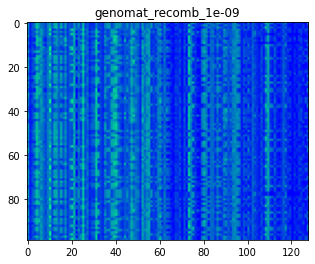

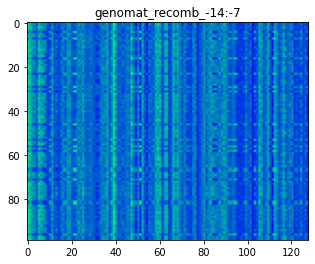

generating 2000 genotype matrices with different recomb from msprime for testing
Data simulation finished


In [ ]:
genob = Genobuilder(
    source='msprime',   #Source of the data with fixed parameters to infer
    num_samples=99,       #Number of sampled haplotypes / number of rows
    seq_len=1e6,          #Length of the randomly sampled genome region in bp
    maf_thresh=0.05,      # Filter rare minor alleles by their frequency
    fixed_dim=128         #Number of columns of the genotype matrix after rescaling
    )

genob.set_parameters(
    sim_source = 'msprime',
    param_name = 'recomb',      #The parameter to infer
    fixed_val = -9,             #The fixed value for the parameter in set A
    param_bounds = (-14, -7),   #The range for the randomly picked parameter value in set B
    log_scale = True            #True if the parameter are given in log10 scale
    )

# Prepare the training and validation datasets
batch_size = 32
xtrain, xval, ytrain, yval = genob.generate_data(num_reps = 2000)
train_data = tf.data.Dataset.from_tensor_slices((xtrain.astype("float16"), ytrain))
train_data = (
      train_data.shuffle(len(ytrain))
      #.cache("/content/train.cache")
      .batch(batch_size)
      .prefetch(2)
)

val_data = tf.data.Dataset.from_tensor_slices((xval.astype("float16"), yval))
val_data = (
      val_data.shuffle(len(yval))
      #.cache("/content/val.cache")
      .batch(batch_size)
      .prefetch(2)
)

# Prepare a list of genotype matrices from a range of parameter values 
# from msprime for testing
xtest, param_values = genob.generate_testdata(num_reps=2000)
test_data = tf.data.Dataset.from_tensor_slices((xtest.astype("float16")))
test_data = (
      test_data
      #.cache("/content/test.cache")
      .batch(batch_size)
      .prefetch(2)
)

print('Data simulation finished')

This part is to generate samples of stdpospim with different error rate.

In [ ]:
# Prepare the optimizer and loss function
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

model = 18
epochs = 5

mcmcgan = MCMCGAN(genob=genob, kernel_name='random walk', calibrated=True)

mcmcgan.build_discriminator(
    model, in_shape=(genob.num_samples, genob.fixed_dim, 1))
mcmcgan.discriminator.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics = ['accuracy'])

training = mcmcgan.discriminator.fit(
    train_data, None, batch_size, epochs, validation_data=val_data, 
    shuffle=True, callbacks=DMonitor(test_data, model, genob, 0))

# Save the keras model
mcmcgan.discriminator.summary()
filename = f'D{model}_trained_{epochs}e.h5'
mcmcgan.discriminator.save(filename)

# Save the genotype builder object
with open('genob.pkl', 'wb') as obj:
    pickle.dump(genob, obj, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

113/113 [==============================] - 12s 110ms/step - loss: 0.6473 - accuracy: 0.7172 - val_loss: 0.6696 - val_accuracy: 0.4325
Epoch 2/5
113/113 [==============================] - 12s 104ms/step - loss: 0.5914 - accuracy: 0.8461 - val_loss: 0.6178 - val_accuracy: 0.5900
Epoch 3/5
113/113 [==============================] - 12s 105ms/step - loss: 0.5788 - accuracy: 0.8658 - val_loss: 0.5672 - val_accuracy: 0.7925
Epoch 4/5
113/113 [==============================] - 12s 105ms/step - loss: 

<Figure size 432x288 with 0 Axes>

In [ ]:
print(training.history['accuracy'][-1])

0.8791666626930237


In [ ]:
# Load another keras model and genotype builder
keras.backend.clear_session()
with open('genob.pkl', 'rb') as obj:
  genob = pickle.load(obj)
filename = 'D18_trained_5e.h5'
mcmcgan = MCMCGAN(genob=genob, kernel_name='random walk', calibrated=True)
mcmcgan.load_discriminator(filename)

1e-09
7.069925305254537e-10
2.6857566394324015e-10
3.800073727499125e-10
2.5317478410301406e-10
3.488806844293544e-11
2.7525331087704975e-10
1.0094250933479066e-10
3.1967331357603394e-09
4.441314035258497e-09
6.697407953325444e-10
1.0121574352591954e-08
3.1765381728606877e-09
4.8872655064461794e-11
4.174537145163516e-10
1.9386032540024413e-09
2.0038341005313475e-10
1.1025382986136479e-09
1.5762571427180565e-09
5.9146723933959514e-09
6.11157069324384e-11
5.5110191271069786e-11
1.3417724521421175e-09
3.003091926353664e-10
1.556780430228563e-09
1.408577746080997e-10
1.2521359410616914e-11
1.546184931384542e-10
4.1017519997324034e-10
3.0889368965688936e-10
1.1986001188011391e-09
7.20293694644652e-10
2.3867197027968986e-08
1.5048000268216103e-10
8.38722544167456e-10
7.957189428152897e-11
4.37628555152983e-11
3.6710294173571984e-11
9.715686389288486e-09
3.077795534218169e-08
2.4707941860381074e-08
2.851950748126008e-09
1.713378607351017e-09
7.497344959684206e-09
6.0060278446607046e-09
3.8042

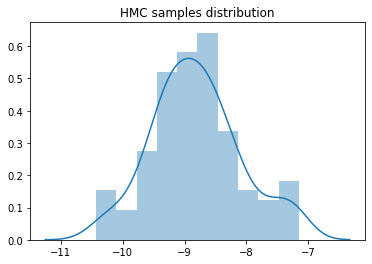

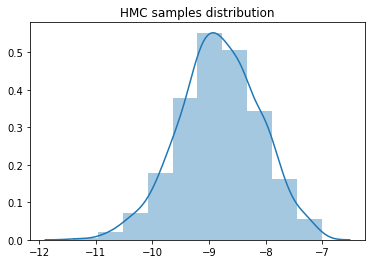

generating 2000 genotype matrices from msprime
generating 2000 genotype matrices with different recomb from msprime
[2.93130791e-11 1.27826022e-08 1.59696768e-08 ... 2.31877425e-08
 5.06385942e-10 1.16574904e-08]
X data shape is: (4000, 99, 128, 1)


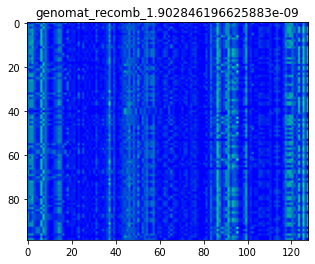

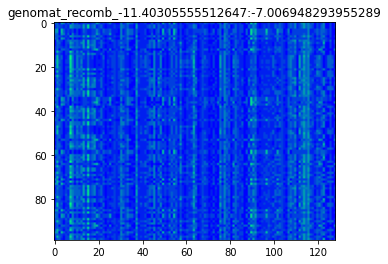

generating 2000 genotype matrices with different recomb from msprime for testing
Epoch 1/5
113/113 [==============================] - 14s 124ms/step - loss: 0.6807 - accuracy: 0.6061 - val_loss: 0.6861 - val_accuracy: 0.6425
Epoch 2/5
113/113 [==============================] - 14s 125ms/step - loss: 0.6686 - accuracy: 0.6100 - val_loss: 0.6606 - val_accuracy: 0.6700
Epoch 3/5
113/113 [==============================] - 14s 124ms/step - loss: 0.6636 - accuracy: 0.6194 - val_loss: 0.6597 - val_accuracy: 0.6950
Epoch 4/5
113/113 [==============================] - 14s 124ms/step - loss: 0.6608 - accuracy: 0.6417 - val_loss: 0.6534 - val_accuracy: 0.6750
Epoch 5/5
113/113 [==============================] - 14s 126ms/step - loss: 0.6570 - accuracy: 0.6461 - val_loss: 0.6556 - val_accuracy: 0.6775
A single iteration of the MCMC-GAN took 914.4100770950317 seconds
1e-09
2.7467426932801162e-09
6.733936315198195e-09
out
out
out
1.4001311207973426e-09
1.0459587579955802e-08
2.9923751851599363e-10
1

In [ ]:
mcmcgan.discriminator.run_eagerly = True
tf.config.run_functions_eagerly(True) 
batch_size = 32
epochs = 5
n_reps = 2000
import time

for i in range(1, 4):

    start_t = time.time()

    # Initial guess must always be a float, otherwise with an int there are errors
    mcmcgan.setup_mcmc(num_mcmc_results=100, num_burnin_steps=10, initial_guess=-9.)

    # Uncalibrated kernels doesn't converge to the desired distribution.
    # MetropolisHastings(UncalibratedHamiltonianMonteCarlo(...)) is functionally
    # the same as HamiltonianMonteCarlo(...).
    sample_mean, sample_stddev, is_accepted, acc_rate = mcmcgan.run_chain()

    print('mean:{:.8f}  stddev:{:.8f}'.format(
        sample_mean.numpy(), sample_stddev.numpy()))
    mcmcgan.hist_samples()

    new_params = np.random.normal(
        loc=sample_mean.numpy(), scale=sample_stddev.numpy(), size=n_reps)
    new_params = new_params[new_params < mcmcgan.genob.param_bounds[1]]
    mcmcgan.genob.param_bounds = (np.min(new_params), np.max(new_params))

    sns.distplot(new_params, bins=10)
    plt.title("HMC samples distribution")
    plt.savefig(f'mcmcgan_{mcmcgan.kernel_name}_it{i}.png')
    plt.show()

    # Prepare the training and validation datasets

    xtrain, xval, ytrain, yval = mcmcgan.genob.generate_data(num_reps = n_reps, paramlist=new_params)
    train_data = tf.data.Dataset.from_tensor_slices((xtrain.astype("float16"), ytrain))
    train_data = (
          train_data.shuffle(len(ytrain))
          #.cache("/content/train.cache")
          .batch(batch_size)
          .prefetch(2)
    )

    val_data = tf.data.Dataset.from_tensor_slices((xval.astype("float16"), yval))
    val_data = (
          val_data.shuffle(len(yval))
          #.cache("/content/val.cache")
          .batch(batch_size)
          .prefetch(2)
    )

    xtest, param_values = mcmcgan.genob.generate_testdata(num_reps=2000)
    test_data = tf.data.Dataset.from_tensor_slices((xtest.astype("float16")))
    test_data = (
          test_data
          #.cache("/content/test.cache")
          .batch(batch_size)
          .prefetch(2)
    )

    mcmcgan.discriminator.fit(
        train_data, None, batch_size, epochs, validation_data=val_data, 
        shuffle=True, callbacks=DMonitor(test_data, model, genob, i))
    
    t = time.time() - start_t
    print(f'A single iteration of the MCMC-GAN took {t} seconds')


In [ ]:
initial_state = -10.
tf.config.run_functions_eagerly(True)

# Initial guess must always be a float, otherwise with an int there are errors
mcmcgan.setup_mcmc(
    kernel='random walk', calibrated=False, genobuilder=genob, 
    num_mcmc_results=100, num_burnin_steps=10, initial_guess=-9.)


initial_kernel_results = mcmcgan.mcmc_kernel.bootstrap_results(initial_state)
previous_state, previous_kernel_results = mcmcgan.mcmc_kernel.one_step(initial_state, initial_kernel_results)

accepted_samples = []
k = 100
while len(accepted_samples) < k:
  proposal, kernel_results = mcmcgan.mcmc_kernel.one_step(previous_state, previous_kernel_results)
  print(proposal)

  dy = mcmcgan.D(previous_state)
  dx = mcmcgan.D(proposal)
  
  ratio = ((1/dy) - 1) / ((1/dx) - 1)
  other_ratio = (1 - np.abs(2*dx - 1)) / (1 - np.abs(2*dy - 1))
  #print(f'The p(x) of the previous state {previous_state} is {dy}')
  #print(f'The p(x) of the proposed state {proposal} is {dx}')
  #print(f'The ratio is {ratio} and the other ratio is {other_ratio}')
  acc_p = tf.math.minimum(1, ratio)

  # The differences between the empirical ratios values are very very similar!

  if np.random.rand() < acc_p:
      #Accepted samples
      print('It got accepted yay!')
      previous_kernel_results = kernel_results
      previous_state = proposal
      accepted_samples.append(proposal)
      print(len(accepted_samples))
  else:
      print(':(')

sns.distplot(accepted_samples, bins=10)
plt.title("HMC samples distribution")
plt.savefig('mcmcgan_hmc.png')
plt.show()

In [ ]:
new_param = np.random.normal(loc=np.mean(accepted_samples), scale=np.std(accepted_samples), size=10000)
mcmcgan.genob.param_bounds = (np.min(new_param), np.max(new_param))

sns.distplot(new_param, bins=10)
plt.title("HMC samples distribution")
plt.savefig('mcmcgan_hmc.png')
plt.show()

In [ ]:
# Prepare the training and validation datasets
batch_size = 32
xtrain, xval, ytrain, yval = genob.generate_data(num_reps = 2000, paramlist=new_param)
train_data = tf.data.Dataset.from_tensor_slices((xtrain.astype("float16"), ytrain))
train_data = (
      train_data.shuffle(len(ytrain))
      #.cache("/content/train.cache")
      .batch(batch_size)
      .prefetch(2)
)

val_data = tf.data.Dataset.from_tensor_slices((xval.astype("float16"), yval))
val_data = (
      val_data.shuffle(len(yval))
      #.cache("/content/val.cache")
      .batch(batch_size)
      .prefetch(2)
)

In [ ]:
mcmcgan.discriminator.fit(
    train_data, None, batch_size, epochs, validation_data=val_data, 
    shuffle=True, callbacks=DMonitor(test_data, model, genob))

In [ ]:
# Initial guess must always be a float, otherwise with an int there are errors
mcmcgan.setup_mcmc(
    kernel='random walk', calibrated=True, genobuilder=genob, 
    num_mcmc_results=100, num_burnin_steps=10, initial_guess=-9.)

# Uncalibrated kernels doesn't converge to the desired distribution.
# MetropolisHastings(UncalibratedHamiltonianMonteCarlo(...)) is functionally
# the same as HamiltonianMonteCarlo(...).
sample_mean, sample_stddev, is_accepted, acc_rate = mcmcgan.run_chain()

print('mean:{:.8f}  stddev:{:.8f}'.format(
    sample_mean.numpy(), sample_stddev.numpy()))

The following chunks of code are experimental and I keep them because they might come in handy later

In [ ]:
 def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
# Print process memory if increased
    current_mem = process.memory_info().rss
    if current_mem > mem:
        mem = current_mem
        print(i, mem)

In [ ]:
#xtest, param_values = genob.generate_testdata(num_reps=10000)
#val = mcmcgan.discriminator.predict(xtest)

plot_average(param_values, val, param_name='effective', name='test', 
             log_scale=False, bins = 100)
#plt.title("HMC samples distribution")
#plt.savefig('mcmcgan_hmc.png')
#plt.show()

In [ ]:
!rm -r /content/results/D*

In [ ]:
#!tar -xvf zarrcache_256-rows_subset.tar

store = zarr.load("zarrcache_256-rows_subset")
data, labels, metadata = store["val/data"], store["val/labels"], store["val/metadata"]
to_pickle = (data, labels)
with open('genmat.pkl', 'wb') as handle:
    pickle.dump(to_pickle, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('genmat.pkl', 'rb') as handle:
    X, y = pickle.load(handle)

print(y.shape)